In [11]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import matplotlib.pyplot as plt

# Exercise 9: Load the Fashion MNIST dataset (introduced in Chapter 10);

- split it into a training set, a validation set, and a test set
- shuffle the training set and save each dataset to multiple TFRecord files.
- Each record should be a serialized Example protobuf with two features:
 - the serialized image (use tf.io.serialize_tensor() to serialize each image), and the label.

 _Note: for large images, you could use tf.io.encode_jpeg() instead.
 This would save a lot of space, but it would lose a bit of image quality._

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [3]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train))
valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [5]:
BytesList = tf.train.BytesList
FloatList = tf.train.FloatList
Int64List = tf.train.Int64List
Feature = tf.train.Feature
Features = tf.train.Features
Example = tf.train.Example


def create_example(image, label):
    image_data = tf.io.serialize_tensor(image)
    #image_data = tf.io.encode_jpeg(image[..., np.newaxis])
    return Example(
        features=Features(
            feature={
                "image": Feature(bytes_list=BytesList(value=[image_data.numpy()])),
                "label": Feature(int64_list=Int64List(value=[label])),
            }))

In [6]:
for image, label in valid_set.take(1):
    print(create_example(image, label))

features {
  feature {
    key: "label"
    value {
      int64_list {
        value: 9
      }
    }
  }
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\010\004\022\010\022\002\010\034\022\002\010\034\"\220\006\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\001\000\000\rI\000\000\001\004\000\000\000\000\001\001\000\000\000\000\000\000\000\000\000\000\000\000\000\003\000$\210\177>6\000\000\000\001\003\004\000\000\003\000\000\000\000\000\000\000\000\000\000\000\000\006\000f\314\260\206\220{\027\000\000\000\000\014\n\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\233\354\317\262k\234\241m@\027M\202H\017\000\000\000\

In [7]:
from contextlib import ExitStack

def write_tfrecords(name, dataset, n_shards=10):
    paths = ["{}.tfrecord-{:05d}-of-{:05d}".format(name, index, n_shards)
             for index in range(n_shards)]
    with ExitStack() as stack:
        writers = [stack.enter_context(tf.io.TFRecordWriter(path))
                   for path in paths]
        for index, (image, label) in dataset.enumerate():
            shard = index % n_shards
            example = create_example(image, label)
            writers[shard].write(example.SerializeToString())
    return paths

In [8]:
train_filepaths = write_tfrecords("my_fashion_mnist.train", train_set)
valid_filepaths = write_tfrecords("my_fashion_mnist.valid", valid_set)
test_filepaths = write_tfrecords("my_fashion_mnist.test", test_set)

Exercise: Then use tf.data to create an efficient dataset for each set. Finally, use a Keras model to train these datasets, including a preprocessing layer to standardize each input feature. Try to make the input pipeline as efficient as possible, using TensorBoard to visualize profiling data.

In [9]:
def preprocess(tfrecord):
    feature_descriptions = {
        "image": tf.io.FixedLenFeature([], tf.string, default_value=""),
        "label": tf.io.FixedLenFeature([], tf.int64, default_value=-1)
    }
    example = tf.io.parse_single_example(tfrecord, feature_descriptions)
    image = tf.io.parse_tensor(example["image"], out_type=tf.uint8)
    image = tf.reshape(image, shape=[28, 28])
    return image, example["label"]

def mnist_dataset(filepaths, n_read_threads=5, shuffle_buffer_size=None,
                  n_parse_threads=5, batch_size=32, cache=True):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [10]:
train_set = mnist_dataset(train_filepaths, shuffle_buffer_size=60000)
valid_set = mnist_dataset(valid_filepaths)
test_set = mnist_dataset(test_filepaths)

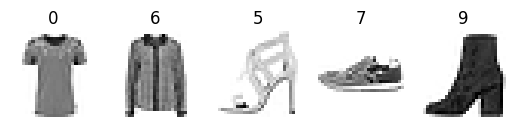

In [12]:
for X, y in train_set.take(1):
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(X[i].numpy(), cmap="binary")
        plt.axis("off")
        plt.title(str(y[i].numpy()))


In [14]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

class Standardization(keras.layers.Layer):
    def adapt(self, data_sample):
        self.means_ = np.mean(data_sample, axis=0, keepdims=True)
        self.stds_ = np.std(data_sample, axis=0, keepdims=True)

    def call(self, inputs):
        return (inputs - self.means_) / (self.stds_ + keras.backend.epsilon())

standardization = Standardization()
# or perhaps soon:
#standardization = keras.layers.Normalization()

sample_image_batches = train_set.take(100).map(lambda image, label: image)
sample_images = np.concatenate(list(sample_image_batches.as_numpy_iterator()),
                               axis=0).astype(np.float32)
standardization.adapt(sample_images)

model = keras.models.Sequential([
    keras.layers.Input(shape=[28, 28]),
    standardization,
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="nadam", metrics=["accuracy"])

In [15]:
from datetime import datetime
logs = os.path.join(os.curdir, "my_logs",
                    "run_" + datetime.now().strftime("%Y%m%d_%H%M%S"))

tensorboard_cb = tf.keras.callbacks.TensorBoard(
    log_dir=logs, histogram_freq=1, profile_batch=10)

model.fit(train_set, epochs=5, validation_data=valid_set,
          callbacks=[tensorboard_cb])

Epoch 1/5
   1712/Unknown 7s 3ms/step - accuracy: 0.8019 - loss: 0.5769

C:\Users\username\Projects\MachineLearning\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8404 - loss: 0.4603 - val_accuracy: 0.8570 - val_loss: 0.3842
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8769 - loss: 0.3409 - val_accuracy: 0.8736 - val_loss: 0.3768
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8906 - loss: 0.2993 - val_accuracy: 0.8806 - val_loss: 0.3423
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8994 - loss: 0.2770 - val_accuracy: 0.8820 - val_loss: 0.3464
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9073 - loss: 0.2561 - val_accuracy: 0.8816 - val_loss: 0.3588


In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

# Exercise 10: In this exercise you will download a dataset, split it, create a tf.data.Dataset to load it and preprocess it efficiently, then build and train a binary classification model containing an Embedding layer.

Exercise: Download the Large Movie Review Dataset, which contains 50,000 movies reviews from the Internet Movie Database. The data is organized in two directories, train and test, each containing a pos subdirectory with 12,500 positive reviews and a neg subdirectory with 12,500 negative reviews. Each review is stored in a separate text file. There are other files and folders (including preprocessed bag-of-words), but we will ignore them in this exercise.

In [17]:
from pathlib import Path

DOWNLOAD_ROOT = "http://ai.stanford.edu/~amaas/data/sentiment/"
FILENAME = "aclImdb_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME, DOWNLOAD_ROOT + FILENAME, extract=True)
path = Path(filepath).parent / "aclImdb"
path

84125825/84125825 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step


WindowsPath('C:/Users/username/.keras/datasets/aclImdb')

In [25]:
path = Path("aclImdb")

In [26]:
for name, subdirs, files in os.walk(path):
    indent = len(Path(name).parts) - len(path.parts)
    print("    " * indent + Path(name).parts[-1] + os.sep)
    for index, filename in enumerate(sorted(files)):
        if index == 3:
            print("    " * (indent + 1) + "...")
            break
        print("    " * (indent + 1) + filename)

aclImdb\
    README
    imdb.vocab
    imdbEr.txt
    test\
        labeledBow.feat
        urls_neg.txt
        urls_pos.txt
        neg\
            0_2.txt
            10000_4.txt
            10001_1.txt
            ...
        pos\
            0_10.txt
            10000_7.txt
            10001_9.txt
            ...
    train\
        labeledBow.feat
        unsupBow.feat
        urls_neg.txt
        ...
        neg\
            0_3.txt
            10000_4.txt
            10001_4.txt
            ...
        pos\
            0_9.txt
            10000_8.txt
            10001_10.txt
            ...
        unsup\
            0_0.txt
            10000_0.txt
            10001_0.txt
            ...


In [27]:
def review_paths(dirpath):
    return [str(path) for path in dirpath.glob("*.txt")]

train_pos = review_paths(path / "train" / "pos")
train_neg = review_paths(path / "train" / "neg")
test_valid_pos = review_paths(path / "test" / "pos")
test_valid_neg = review_paths(path / "test" / "neg")

len(train_pos), len(train_neg), len(test_valid_pos), len(test_valid_neg)

(12500, 12500, 12500, 12500)

Exercise: Split the test set into a validation set (15,000) and a test set (10,000).

In [28]:
np.random.shuffle(test_valid_pos)

test_pos = test_valid_pos[:5000]
test_neg = test_valid_neg[:5000]
valid_pos = test_valid_pos[5000:]
valid_neg = test_valid_neg[5000:]

Exercise: Use tf.data to create an efficient dataset for each set.

Since the dataset fits in memory, we can just load all the data using pure Python code and use tf.data.Dataset.from_tensor_slices():

In [31]:
def imdb_dataset(filepaths_positive, filepaths_negative):
    reviews = []
    labels = []
    for filepaths, label in ((filepaths_negative, 0), (filepaths_positive, 1)):
        for filepath in filepaths:
            with open(filepath, encoding='latin-1') as review_file:
                reviews.append(review_file.read())
            labels.append(label)
    return tf.data.Dataset.from_tensor_slices(
        (tf.constant(reviews), tf.constant(labels)))

In [32]:
for X, y in imdb_dataset(train_pos, train_neg).take(3):
    print(X)
    print(y)
    print()

tf.Tensor(b"Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int32)

tf.Tensor(b"Airport '77 starts as a brand new luxury 747 plane is loaded up with valuable paintings & such belonging to rich businessman Philip Stevens (James Stewart) who is flying them & a bunch of VIP's to his estate in preparation of it being opened to the public a

In [34]:
def imdb_dataset(filepaths_positive, filepaths_negative, n_read_threads=5):
    dataset_neg = tf.data.TextLineDataset(filepaths_negative,
                                          num_parallel_reads=n_read_threads)
    dataset_neg = dataset_neg.map(lambda review: (review, 0))
    dataset_pos = tf.data.TextLineDataset(filepaths_positive,
                                          num_parallel_reads=n_read_threads)
    dataset_pos = dataset_pos.map(lambda review: (review, 1))
    return tf.data.Dataset.concatenate(dataset_pos, dataset_neg)

In [35]:

batch_size = 32

train_set = imdb_dataset(train_pos, train_neg).shuffle(25000).batch(batch_size).prefetch(1)
valid_set = imdb_dataset(valid_pos, valid_neg).batch(batch_size).prefetch(1)
test_set = imdb_dataset(test_pos, test_neg).batch(batch_size).prefetch(1)

Exercise: Create a binary classification model, using a TextVectorization layer to preprocess each review. If the TextVectorization layer is not yet available (or if you like a challenge), try to create your own custom preprocessing layer: you can use the functions in the tf.strings package, for example lower() to make everything lowercase, regex_replace() to replace punctuation with spaces, and split() to split words on spaces. You should use a lookup table to output word indices, which must be prepared in the adapt() method.

Let's first write a function to preprocess the reviews, cropping them to 300 characters, converting them to lower case, then replacing <br /> and all non-letter characters to spaces, splitting the reviews into words, and finally padding or cropping each review so it ends up with exactly n_words tokens:

In [36]:
def preprocess(X_batch, n_words=50):
    shape = tf.shape(X_batch) * tf.constant([1, 0]) + tf.constant([0, n_words])
    Z = tf.strings.substr(X_batch, 0, 300)
    Z = tf.strings.lower(Z)
    Z = tf.strings.regex_replace(Z, b"<br\\s*/?>", b" ")
    Z = tf.strings.regex_replace(Z, b"[^a-z]", b" ")
    Z = tf.strings.split(Z)
    return Z.to_tensor(shape=shape, default_value=b"<pad>")

X_example = tf.constant(["It's a great, great movie! I loved it.", "It was terrible, run away!!!"])
preprocess(X_example)

<tf.Tensor: shape=(2, 50), dtype=string, numpy=
array([[b'it', b's', b'a', b'great', b'great', b'movie', b'i', b'loved',
        b'it', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>'],
       [b'it', b'was', b'terrible', b'run', b'away', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'

Now let's write a second utility function that will take a data sample with the same format as the output of the preprocess() function, and will output the list of the top max_size most frequent words, ensuring that the padding token is first:

In [37]:
from collections import Counter

def get_vocabulary(data_sample, max_size=1000):
    preprocessed_reviews = preprocess(data_sample).numpy()
    counter = Counter()
    for words in preprocessed_reviews:
        for word in words:
            if word != b"<pad>":
                counter[word] += 1
    return [b"<pad>"] + [word for word, count in counter.most_common(max_size)]

get_vocabulary(X_example)

[b'<pad>',
 b'it',
 b'great',
 b's',
 b'a',
 b'movie',
 b'i',
 b'loved',
 b'was',
 b'terrible',
 b'run',
 b'away']

Now we are ready to create the TextVectorization layer. Its constructor just saves the hyperparameters (max_vocabulary_size and n_oov_buckets). The adapt() method computes the vocabulary using the get_vocabulary() function, then it builds a StaticVocabularyTable (see Chapter 16 for more details). The call() method preprocesses the reviews to get a padded list of words for each review, then it uses the StaticVocabularyTable to lookup the index of each word in the vocabulary:

In [38]:
class TextVectorization(keras.layers.Layer):

    def __init__(self, max_vocabulary_size=1000, n_oov_buckets=100, dtype=tf.string, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        self.max_vocabulary_size = max_vocabulary_size
        self.n_oov_buckets = n_oov_buckets

    def adapt(self, data_sample):
        self.vocab = get_vocabulary(data_sample, self.max_vocabulary_size)
        words = tf.constant(self.vocab)
        word_ids = tf.range(len(self.vocab), dtype=tf.int64)
        vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
        self.table = tf.lookup.StaticVocabularyTable(vocab_init, self.n_oov_buckets)

    def call(self, inputs):
        preprocessed_inputs = preprocess(inputs)
        return self.table.lookup(preprocessed_inputs)

In [39]:
text_vectorization = TextVectorization()

text_vectorization.adapt(X_example)
text_vectorization(X_example)

<tf.Tensor: shape=(2, 50), dtype=int64, numpy=
array([[ 1,  3,  4,  2,  2,  5,  6,  7,  1,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0],
       [ 1,  8,  9, 10, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0]])>

Looks good! As you can see, each review was cleaned up and tokenized, then each word was encoded as its index in the vocabulary (all the 0s correspond to the <pad> tokens).

Now let's create another TextVectorization layer and let's adapt it to the full IMDB training set (if the training set did not fit in RAM, we could just use a smaller sample of the training set by calling train_set.take(500)):

In [40]:
max_vocabulary_size = 1000
n_oov_buckets = 100

sample_review_batches = train_set.map(lambda review, label: review)
sample_reviews = np.concatenate(list(sample_review_batches.as_numpy_iterator()),
                                axis=0)

text_vectorization = TextVectorization(max_vocabulary_size, n_oov_buckets,
                                       input_shape=[])
text_vectorization.adapt(sample_reviews)

C:\Users\username\AppData\Local\Temp\ipykernel_16140\1183609878.py:3: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(dtype=dtype, **kwargs)


In [41]:
text_vectorization(X_example)

<tf.Tensor: shape=(2, 50), dtype=int64, numpy=
array([[  9,  14,   2,  64,  64,  12,   5, 256,   9,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  9,  13, 269, 532, 334,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])>

In [42]:
text_vectorization.vocab[:10]

[b'<pad>', b'the', b'a', b'of', b'and', b'i', b'to', b'is', b'this', b'it']

These are the most common words in the reviews.

Now to build our model we will need to encode all these word IDs somehow. One approach is to create bags of words: for each review, and for each word in the vocabulary, we count the number of occurences of that word in the review. For example:

In [43]:
simple_example = tf.constant([[1, 3, 1, 0, 0], [2, 2, 0, 0, 0]])
tf.reduce_sum(tf.one_hot(simple_example, 4), axis=1)

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[2., 2., 0., 1.],
       [3., 0., 2., 0.]], dtype=float32)>

In [53]:
class BagOfWords(keras.layers.Layer):
    def __init__(self, n_tokens, **kwargs):
        super().__init__(dtype=tf.float32, **kwargs)
        self.n_tokens = n_tokens

    def call(self, inputs):
        # inputs: int64/32 token IDs
        one_hot = tf.one_hot(inputs, self.n_tokens)  # float32
        bag = tf.reduce_sum(one_hot, axis=1)[:, 1:]  # drop <pad> column
        return bag

In [ ]:
n_tokens = max_vocabulary_size + n_oov_buckets + 1  # +1 for <pad>
bag_of_words = BagOfWords(n_tokens)

model = keras.models.Sequential([
    text_vectorization,      # input: string
    bag_of_words,            # output: float32
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid"),
])

model.compile(loss="binary_crossentropy",
              optimizer="nadam",
              metrics=["accuracy"])

model.fit(train_set, epochs=5, validation_data=valid_set)